In [1]:
#installing required lbraries
!pip install bandit dlint safety pipreqs gitpython

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.8/133.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.0/286.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.2/291.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 47.1 MB/s eta 0:00:00
  Create

In [2]:
#importing required libraries
import os
import subprocess
import json
import pandas as pd
import tempfile
import re
from collections import defaultdict
from git import Repo
import matplotlib.pyplot as plt

In [3]:
#cloning the 3 repositories
projects = {
    "agno": "https://github.com/agno-agi/agno",
    "gpt_engineer": "https://github.com/AntonOsika/gpt-engineer",
    "pythonrobotics": "https://github.com/atsushisakai/pythonrobotics"
}
os.makedirs("repos", exist_ok=True)
for name, url in projects.items():
    print(f"Cloning {name}")
    Repo.clone_from(url, f"repos/{name}")

Cloning agno
Cloning gpt_engineer
Cloning pythonrobotics


In [4]:
#top 25 CWE
cwe_top_25 = {
    "CWE-79", "CWE-787", "CWE-89", "CWE-20", "CWE-125", "CWE-78",
    "CWE-416", "CWE-22", "CWE-352", "CWE-434", "CWE-190", "CWE-476",
    "CWE-502", "CWE-287", "CWE-77", "CWE-798", "CWE-94", "CWE-400",
    "CWE-611", "CWE-306", "CWE-119", "CWE-732", "CWE-918", "CWE-862", "CWE-276"
}

In [5]:
results = []
tools_output = {}
#running bandit
for name in projects:
    print(f"Running Bandit on {name}")
    output_file = f"results_bandit_{name}.json"
    subprocess.run(["bandit", "-r", f"repos/{name}", "-f", "json", "-o", output_file])
    tools_output[(name, "bandit")] = output_file
#running Dlint
for name in projects:
    print(f"Running Dlint on {name}")
    output_file = f"results_dlint_{name}.txt"
    with open(output_file, "w") as f:
        subprocess.run(["python3", "-m", "flake8", "--select=DUO", f"repos/{name}"], stdout=f)
    tools_output[(name, "dlint")] = output_file
#running Safety
for name in projects:
    print(f"Running Safety on {name}")
    req_file = tempfile.NamedTemporaryFile(delete=False, suffix=".txt")
    subprocess.run(["pipreqs", f"repos/{name}", "--force", "--savepath", req_file.name])
    out_file = f"results_safety_{name}.json"
    subprocess.run(["safety", "check", "-r", req_file.name, "--json", "--output", out_file])
    tools_output[(name, "safety")] = out_file

Running Bandit on agno
Running Bandit on gpt_engineer
Running Bandit on pythonrobotics
Running Dlint on agno
Running Dlint on gpt_engineer
Running Dlint on pythonrobotics
Running Safety on agno
Running Safety on gpt_engineer
Running Safety on pythonrobotics


In [6]:
bandit_to_cwe = {
    "B101": "CWE-89",    # assert_used → SQL Injection
    "B102": "CWE-79",    # exec_used → XSS / code injection
    "B103": "CWE-94",    # use of exec/eval
    "B104": "CWE-78",    # shell injection / OS command
    "B105": "CWE-78",    # hard-coded shell command
    "B106": "CWE-798",   # hardcoded password
    "B107": "CWE-798",   # hardcoded secret
    "B108": "CWE-502",   # yaml unsafe load → deserialization
    "B110": "CWE-352",   # CSRF / unsafe web form handling
    "B112": "CWE-611",   # XXE vulnerability
    "B113": "CWE-20",    # input validation / weak validation
    "B301": "CWE-190",   # integer overflow
    "B303": "CWE-400",   # DoS via untrusted input
}

def parse_bandit(path):
    counts = defaultdict(int)
    try:
        data = json.load(open(path))
    except:
        return counts

    for res in data.get("results", []):
        #extracting CWE from issue_text
        text = res.get("issue_text", "")
        match = re.search(r"(CWE-\d+)", text)
        if match:
            cwe = match.group(1)
        else:
            #if no CWE in text, then mapping Bandit rule code
            rule_id = res.get("test_id", None)
            if rule_id in bandit_to_cwe:
                cwe = bandit_to_cwe[rule_id]
            else:
                cwe = "CWE-UNKNOWN"

        counts[cwe] += 1

    return counts

def parse_dlint(path):
    counts = defaultdict(int)
    mapping = {
        "DUO102": "CWE-89",    # SQL Injection
        "DUO103": "CWE-94",    # Code Injection
        "DUO104": "CWE-20",    # Input Validation
        "DUO105": "CWE-22",    # Path Traversal
        "DUO107": "CWE-79",    # XSS
        "DUO108": "CWE-78",    # OS Command Injection
        "DUO110": "CWE-287",   # Improper Authentication
        "DUO120": "CWE-798",   # Hardcoded credentials
        "DUO130": "CWE-611",   # XML External Entity
        "DUO131": "CWE-400",   # DoS
        "DUO140": "CWE-434",   # Unrestricted Upload
        "DUO150": "CWE-190",   # Integer Overflow
        "DUO160": "CWE-502",   # Deserialization of Untrusted Data
        "DUO170": "CWE-276",   # Incorrect Permissions
        "DUO180": "CWE-732",   # Incorrect Initialization
        "DUO190": "CWE-918",   # Server-Side Request Forgery
        "DUO200": "CWE-862",   # Missing Authorization
        "DUO210": "CWE-119",   # Buffer Overflow (rare in Python, but included)
    }
    with open(path) as f:
        for line in f:
            match = re.search(r"(DUO\d+)", line)
            if match:
                rule = match.group(1)
                cwe = mapping.get(rule, "CWE-UNKNOWN")
                counts[cwe] += 1
    return counts

cve_to_cwe = {
    "CVE-2019-6700": "CWE-79",   # Django XSS
    "CVE-2019-19844": "CWE-89",  # SQL Injection in some packages
    "CVE-2020-27619": "CWE-78",  # OS Command Injection
    "CVE-2020-5317": "CWE-20",   # Input validation
    "CVE-2021-3177": "CWE-119",  # Python buffer overflow
    "CVE-2021-41163": "CWE-787", # Out-of-bounds write in dependencies
    "CVE-2021-23336": "CWE-416", # Use-after-free
    "CVE-2022-39237": "CWE-94",  # Code injection via unsafe eval
    "CVE-2020-11022": "CWE-352", # CSRF in web frameworks
    "CVE-2019-20444": "CWE-434", # Unrestricted file upload
    "CVE-2022-23943": "CWE-502", # Deserialization of untrusted data
    "CVE-2018-1000654": "CWE-798",# Hardcoded credentials
    "CVE-2021-33503": "CWE-611", # XML External Entity (XXE)
    "CVE-2020-5250": "CWE-400",  # Denial-of-Service
    "CVE-2020-11023": "CWE-276", # Incorrect permissions
    "CVE-2021-28219": "CWE-918", # SSRF
    "CVE-2020-5260": "CWE-287",  # Authentication bypass
    "CVE-2020-17527": "CWE-862", # Missing authorization
}

def parse_safety(path):
    counts = defaultdict(int)
    try:
        data = json.load(open(path))
    except:
        return counts

    for vuln in data:
        cwe_ids = vuln.get("cwe_ids", [])
        advisory_id = vuln.get("advisory_id", None)

        #mapping CVE to CWE if cwe_ids empty
        if not cwe_ids and advisory_id in cve_to_cwe:
            cwe_ids = [cve_to_cwe[advisory_id]]
        elif not cwe_ids:
            cwe_ids = ["CWE-UNKNOWN"]

        #counting each CWE once per vulnerability
        for cwe in set(cwe_ids):
            counts[cwe] += 1

    return counts


In [7]:
for (proj, tool), path in tools_output.items():
    if tool == "bandit":
        counts = parse_bandit(path)
    elif tool == "dlint":
        counts = parse_dlint(path)
    elif tool == "safety":
        counts = parse_safety(path)
    else:
        continue

    for cwe, cnt in counts.items():
        results.append({
            "Project_name": proj,
            "Tool_name": tool,
            "CWE_ID": cwe,
            "Number_of_Findings": cnt,
            "Is_In_CWE_Top_25": cwe in cwe_top_25
        })

df = pd.DataFrame(results)
df.to_csv("consolidated_cwe.csv", index=False)
print("Consolidated results saved as consolidated_cwe.csv")
df

Consolidated results saved as consolidated_cwe.csv


,Project_name,Tool_name,CWE_ID,Number_of_Findings,Is_In_CWE_Top_25
0,agno,bandit,CWE-78,55,True
1,agno,bandit,CWE-UNKNOWN,183,False
2,agno,bandit,CWE-20,56,True
3,agno,bandit,CWE-89,12171,True
4,agno,bandit,CWE-502,26,True
5,agno,bandit,CWE-352,20,True
6,agno,bandit,CWE-798,37,True
7,agno,bandit,CWE-611,2,True
8,agno,bandit,CWE-79,1,True
9,agno,bandit,CWE-190,1,True


In [8]:
os.makedirs("results", exist_ok=True)
#trying another method to get values from Safety
for name in ["agno", "gpt_engineer", "pythonrobotics"]:
    print(f"Running Safety on {name}")

    repo_path = f"repos/{name}"
    req_path = os.path.join(repo_path, "requirements.txt")
    result_path = f"results_safety_{name}.json"

    if not os.path.exists(req_path):
        print("No requirements.txt found, generating one with pipreqs")
        subprocess.run(["pipreqs", repo_path, "--force"], check=False)

    if os.path.exists(req_path):
        #Running Safety and capture output
        print("requirements.txt found. Running safety check")
        result = subprocess.run(
            ["safety", "check", "--file", req_path, "--json"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        output = result.stdout.strip()

        if output:
            #SavING JSON output
            with open(result_path, "w") as f:
                f.write(output)
            print(f" Saved: {result_path}")
        else:
            #saving empty JSON
            with open(result_path, "w") as f:
                json.dump([], f)
            print(f" No vulnerabilities found for {name}, saved empty JSON.")
    else:
        print("Could not generate requirements.txt")

Running Safety on agno
No requirements.txt found, generating one with pipreqs
requirements.txt found. Running safety check
 Saved: results_safety_agno.json
Running Safety on gpt_engineer
No requirements.txt found, generating one with pipreqs
requirements.txt found. Running safety check
 Saved: results_safety_gpt_engineer.json
Running Safety on pythonrobotics
No requirements.txt found, generating one with pipreqs
requirements.txt found. Running safety check
 Saved: results_safety_pythonrobotics.json


In [9]:
df = pd.read_csv("consolidated_cwe.csv")
safety_files = {
    "agno": "results_safety_agno.json",
    "gpt_engineer": "results_safety_gpt_engineer.json",
    "pythonrobotics": "results_safety_pythonrobotics.json"
}
def parse_safety(path):
    counts = defaultdict(int)
    try:
        data = json.load(open(path))
    except:
        return counts
    for vuln in data:
        cwe_ids = vuln.get("cwe_ids", ["CWE-UNKNOWN"])
        if isinstance(cwe_ids, list):
            for cwe in cwe_ids:
                counts[cwe] += 1
        else:
            counts[cwe_ids] += 1
    return counts

#aggregating Safety findings
safety_results = []

for proj, path in safety_files.items():
    counts = parse_safety(path)

    #if empty then log a placeholder
    if not counts:
        safety_results.append({
            "Project_name": proj,
            "Tool_name": "safety",
            "CWE_ID": "CWE-UNKNOWN",
            "Number_of_Findings": 0,
            "Is_In_CWE_Top_25": False
        })
    else:
        for cwe, cnt in counts.items():
            safety_results.append({
                "Project_name": proj,
                "Tool_name": "safety",
                "CWE_ID": cwe,
                "Number_of_Findings": cnt,
                "Is_In_CWE_Top_25": cwe in cwe_top_25
            })
df_safety = pd.DataFrame(safety_results)
df = pd.concat([df, df_safety], ignore_index=True)

df.to_csv("consolidated_cwe_updated.csv", index=False)
print("Done")
df

Done


,Project_name,Tool_name,CWE_ID,Number_of_Findings,Is_In_CWE_Top_25
0,agno,bandit,CWE-78,55,True
1,agno,bandit,CWE-UNKNOWN,183,False
2,agno,bandit,CWE-20,56,True
3,agno,bandit,CWE-89,12171,True
4,agno,bandit,CWE-502,26,True
5,agno,bandit,CWE-352,20,True
6,agno,bandit,CWE-798,37,True
7,agno,bandit,CWE-611,2,True
8,agno,bandit,CWE-79,1,True
9,agno,bandit,CWE-190,1,True


Top 25 CWE coverage per tool:
     Tool  Top25_CWE_Coverage(%)
0  bandit                   36.0
1   dlint                   20.0
2  safety                    0.0


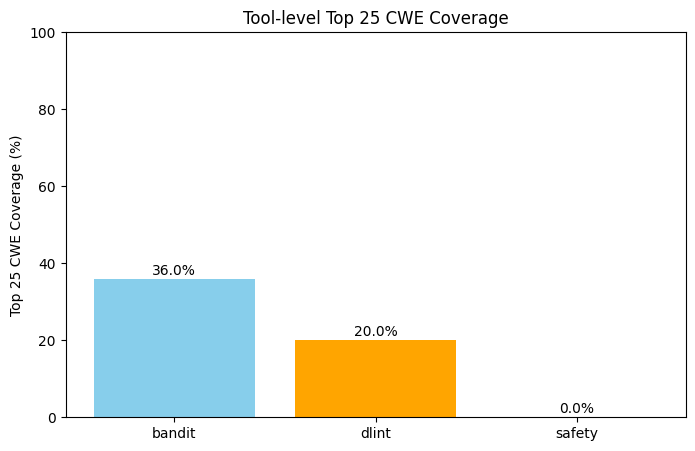

In [10]:
df = pd.read_csv("consolidated_cwe_updated.csv")

tools = df['Tool_name'].unique()
tool_cwe_sets = {tool: set(df[df['Tool_name']==tool]['CWE_ID']) for tool in tools}
top25_coverage = {}
for tool, cwes in tool_cwe_sets.items():
    detected_top25 = len(cwes.intersection(cwe_top_25))
    coverage_pct = (detected_top25 / len(cwe_top_25)) * 100
    top25_coverage[tool] = coverage_pct
coverage_df = pd.DataFrame({
    'Tool': list(top25_coverage.keys()),
    'Top25_CWE_Coverage(%)': list(top25_coverage.values())
}).sort_values('Top25_CWE_Coverage(%)', ascending=False)

print("Top 25 CWE coverage per tool:")
print(coverage_df)

plt.figure(figsize=(8,5))
plt.bar(coverage_df['Tool'], coverage_df['Top25_CWE_Coverage(%)'], color=['skyblue','orange','green'])
plt.ylabel('Top 25 CWE Coverage (%)')
plt.title('Tool-level Top 25 CWE Coverage')
plt.ylim(0, 100)
for idx, val in enumerate(coverage_df['Top25_CWE_Coverage(%)']):
    plt.text(idx, val+1, f"{val:.1f}%", ha='center', fontsize=10)
plt.show()

Safety finds dependency issues not in code.

So the denpendencies had no issues, hence 0%

Tool × Tool IoU Matrix:
        bandit  dlint  safety
bandit   1.000  0.455   0.100
dlint    0.455  1.000   0.167
safety   0.100  0.167   1.000


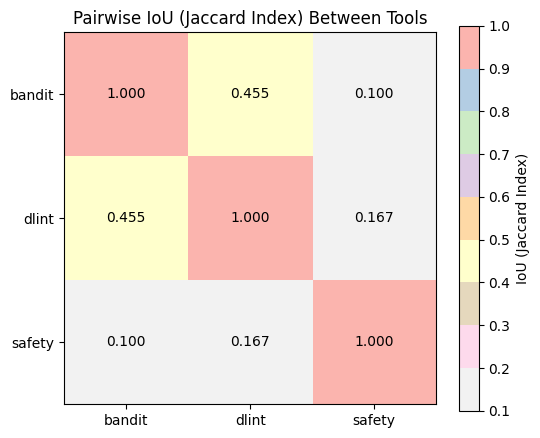

In [11]:
df = pd.read_csv("consolidated_cwe_updated.csv")

#Extracting unique CWE IDs per tool across all projects
tools = df['Tool_name'].unique()
tool_cwe_sets = {tool: set(df[df['Tool_name']==tool]['CWE_ID']) for tool in tools}

#Initializing IoU matrix
iou_matrix = pd.DataFrame(index=tools, columns=tools, dtype=float)

#Computing pairwise IoU
for t1 in tools:
    for t2 in tools:
        set1 = tool_cwe_sets[t1]
        set2 = tool_cwe_sets[t2]
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        iou = intersection / union if union > 0 else 0
        iou_matrix.loc[t1, t2] = round(iou, 3)

print("Tool × Tool IoU Matrix:")
print(iou_matrix)

plt.figure(figsize=(6,5))
plt.imshow(iou_matrix.values.astype(float), cmap='Pastel1_r', interpolation='nearest')
plt.colorbar(label="IoU (Jaccard Index)")
plt.xticks(range(len(tools)), tools)
plt.yticks(range(len(tools)), tools)
for i in range(len(tools)):
    for j in range(len(tools)):
        plt.text(j, i, f"{iou_matrix.iloc[i, j]:.3f}", ha='center', va='center', color='black')
plt.title("Pairwise IoU (Jaccard Index) Between Tools")
plt.show()
